# split training queries by teacher model performance

In [7]:
import os
import gzip
import pickle
data_folder = '../../msmarco'

ce_scores_file = os.path.join(data_folder, 'cross-encoder-ms-marco-MiniLM-L-6-v2-scores.pkl.gz')

with gzip.open(ce_scores_file, 'rb') as fIn:
    ce_scores = pickle.load(fIn)

In [2]:
qrel_file = f"../../msmarco/qrels.train.tsv"
from collections import defaultdict
qrels = defaultdict(dict)
with open(qrel_file) as f:
    for line in f:
        try:
            qid, _, did, rel = line.strip().split("\t")
        except:
            qid, _, did, rel = line.strip().split(" ")
        if int(rel) > 0:
            qrels[qid][did] = int(rel)

In [3]:
import pytrec_eval
from statistics import mean
import scipy.stats as stats
from collections import defaultdict
VALIDATION_METRIC = 'recip_rank' 

trec_eval = pytrec_eval.RelevanceEvaluator(qrels, {VALIDATION_METRIC})

In [4]:
good_q = []
bad_q = []

for q in ce_scores:
    ce_scores_str = defaultdict(dict)
    ce_scores_str[str(q)] = {str(d): ce_scores[q][d] for d in ce_scores[q]}
    eval_scores_teacher = trec_eval.evaluate(ce_scores_str)
    if len(eval_scores_teacher) == 0:
        continue
    if eval_scores_teacher[str(q)][VALIDATION_METRIC] >= 0.5:
        good_q.append(str(q))
    elif eval_scores_teacher[str(q)][VALIDATION_METRIC] < 0.3 and eval_scores_teacher[str(q)][VALIDATION_METRIC] > 0.01:
        bad_q.append(str(q))

good_q = set(good_q)
bad_q = set(bad_q)

In [5]:
del qrels

In [9]:
import json
open("../msmarco/teacher_good_q_0.5.json", "w").write(json.dumps(list(good_q)))
open("../msmarco/teacher_bad_q_0.3.json", "w").write(json.dumps(list(bad_q)))

2506701

## generate gradient

In [1]:
import json
bad_q = set(json.loads(open("../msmarco/teacher_good_q_0.5.json").readline()))

In [2]:
import tqdm
import json
train_query_file = "../../msmarco/training_queries/train_queries_distill_splade_colbert_0.json"
#train_queries_good = dict()
train_queries_bad = dict()

with open(train_query_file) as f: #training_queries_splade_max_156000_ceclean.json
    for line in tqdm.tqdm(f):
        qid = line.split("\t")[0]
        '''
        if qid in good_q:
            train_queries_good[qid] = json.loads(line.split("\t")[1])

            train_queries_good[qid]['neg'] = [x for x in train_queries_good[qid]['neg'] if x[0] <= 20]
            if len(train_queries_good[line.split("\t")[0]]['neg']) == 0:
                del train_queries_good[line.split("\t")[0]]
                continue
        '''
        if qid in bad_q:
            train_queries_bad[qid] = json.loads(line.split("\t")[1])

            train_queries_bad[qid]['neg'] = [x for x in train_queries_bad[qid]['neg'] if x[0] <= 20]
            if len(train_queries_bad[line.split("\t")[0]]['neg']) == 0:
                del train_queries_bad[line.split("\t")[0]]
                continue


502937it [00:15, 32759.91it/s]


In [3]:
#FROM Sentence-BERT(https://github.com/UKPLab/sentence-transformers/blob/afee883a17ab039120783fd0cffe09ea979233cf/examples/training/ms_marco/train_bi-encoder_margin-mse.py) with minimal changes.
#Original License Apache2, NOTE: Trained MSMARCO models are NonCommercial (from dataset License)

import sys
import json
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, LoggingHandler, util, evaluation, InputExample
from sbert import SentenceTransformerA
import models
import logging
from datetime import datetime
import gzip
import os
import tarfile
import tqdm
from torch.utils.data import Dataset
import random
from shutil import copyfile
import pickle
import argparse
import losses
import torch
from collections import defaultdict
from data import MSMARCODataset
from evaluate_training import evaluate_trainining
import transformers
#from colbert_model import DETeacher


data_folder = '../../msmarco'

#### Read the corpus file containing all the passages. Store them in the corpus dict
corpus = {}  # dict in the format: passage_id -> passage. Stores all existing passages
collection_filepath = os.path.join(data_folder, 'collection.tsv')


with open(collection_filepath, 'r', encoding='utf8') as fIn:
    for line in fIn:
        pid, passage = line.strip().split("\t")
        pid = int(pid)
        corpus[pid] = passage

### Read the train queries, store in queries dict

queries = {}  # dict in the format: query_id -> query. Stores all training queries
queries_filepath = os.path.join(data_folder, 'queries.train.tsv')

with open(queries_filepath, 'r', encoding='utf8') as fIn:
    for line in fIn:
        qid, query = line.strip().split("\t")
        qid = int(qid)
        queries[qid] = query

        
ce_scores_file = os.path.join(data_folder, 'cross-encoder-ms-marco-MiniLM-L-6-v2-scores.pkl.gz')

with gzip.open(ce_scores_file, 'rb') as fIn:
    ce_scores = pickle.load(fIn)

In [4]:
#model_name = "output/colbert_splade_distill_num1_kldiv_multipos_focal_default_alpha0.2_denoiseFalse_num20_kldiv_multipos_focal5-lr1e-05-batch_size_8x4-2022-11-10/10/0_ColBERTTransformer"
#model_name = "output/colbert_splade_distill_num1_kldiv_multipos_default_alpha0.2_denoiseFalse_num20_kldiv_multipos5-lr1e-05-batch_size_8x4-2022-11-09/10000/0_ColBERTTransformer"


word_embedding_model = models.ColBERTTransformer(model_name, max_seq_length=256)
checkpoint = torch.load(os.path.join(model_name, "checkpoint.pt"), map_location='cpu')
word_embedding_model.load_state_dict(checkpoint)
word_embedding_model.to('cuda')
model = SentenceTransformerA(modules=[word_embedding_model])


In [5]:
# For training the SentenceTransformer model, we need a dataset, a dataloader, and a loss used for training.
train_dataset = MSMARCODataset(queries=train_queries_bad, corpus=corpus, ce_scores=ce_scores, loss_type="kldiv_focal", num_neg=5, topk = 20)
train_dataloader = DataLoader(train_dataset, shuffle=False, batch_size=4, drop_last=True)
train_dataloader.collate_fn = model.smart_batching_collate
data_iterator = iter(train_dataloader)

In [6]:

#train_loss = losses.KLDivLossColBERT(model=model)
train_loss = losses.KLDivLossColBERT(model=model, focal=True, gamma = 5.0)

# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
param_optimizer = list(train_loss.named_parameters())
optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
train_loss.train()

KLDivLossColBERT(
  (model): SentenceTransformerA(
    (0): MLMTransformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: DataParallel 
  )
  (loss_fct): KLDivLoss()
)

In [7]:
gradients = []
i = 0
for data in tqdm.tqdm(data_iterator):
    train_loss.zero_grad()
    if i == 10000:
        break
    i += 1
    features, labels = data
    loss_value = train_loss(features, labels)
    loss_value.backward()
    gradients.append(model[0].linear.weight.grad.norm(2).tolist())

  0%|          | 0/46550 [00:00<?, ?it/s]/home/ec2-user/efs/splade_cls/training_with_sentence_transformers/data.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  target_score = torch.nn.functional.log_softmax(target_score)
 21%|██▏       | 10000/46550 [33:29<2:02:24,  4.98it/s]


In [8]:
open("gradient_klfr_10_good_sample10k.json","w").write(json.dumps(gradients))
#open("gradient_klfr2.0_1k_good_sample1000.json","w").write(json.dumps(gradients))

214401

In [6]:
loss_value

NameError: name 'loss_value' is not defined

## plot

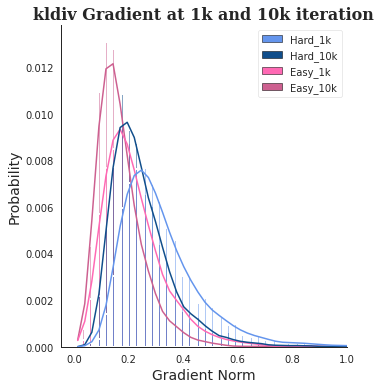

In [29]:
import seaborn as sns
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import pyplot

nbin = 100
grad_kl_b_1k = json.loads(open("../qualitative/gradient_kldiv_1k_bad_sample10k.json").readline())
grad_kl_g_1k = json.loads(open("../qualitative/gradient_kldiv_1k_good_sample10k.json").readline())
grad_kl_b_10k = json.loads(open("../qualitative/gradient_kldiv_10k_bad_sample10k.json").readline())
grad_kl_g_10k = json.loads(open("../qualitative/gradient_kldiv_10k_good_sample10k.json").readline())

lines = [grad_kl_b_1k, grad_kl_b_10k, grad_kl_g_1k,  grad_kl_g_10k]
colors = ['cornflowerblue', '#104E8B', '#FF69B4', '#CD6090']


chart = sns.displot(data=lines, kind='hist',
            linewidth=2, palette = colors,fill=True,kde=True, stat='probability',edgecolor=None,legend=False)#, color": colors[i]})

plt.xlim(-0.05,1)
plt.xlabel("Gradient Norm",fontsize = 14)
plt.ylabel("Probability",fontsize = 14)
plt.title("kldiv Gradient at 1k and 10k iteration", fontsize = 16, fontname = 'serif', fontweight="bold")
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in colors]
labels= ["Hard_1k","Hard_10k", "Easy_1k","Easy_10k"]
plt.legend(handles, labels)

plt.savefig('grad_kl.pdf',dpi=300,  bbox_inches='tight')
plt.show()

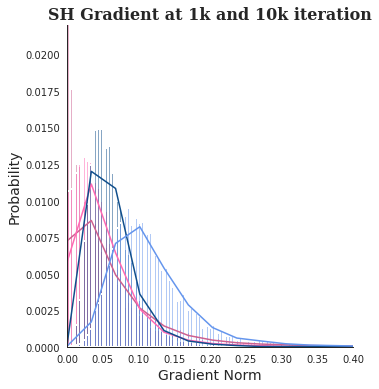

In [24]:
import seaborn as sns
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


nbin = 100
grad_kl_b_1k = json.loads(open("../qualitative/gradient_klfr_1k_bad_sample10k.json").readline())
grad_kl_g_1k = json.loads(open("../qualitative/gradient_klfr_10k_temp_good_sample10k.json").readline())
grad_kl_b_10k = json.loads(open("../qualitative/gradient_klfr_10k_bad_sample10k.json").readline())
grad_kl_g_10k = json.loads(open("../qualitative/gradient_klfr_1k_temp_good_sample10k.json").readline())


lines = [grad_kl_b_1k, grad_kl_b_10k, grad_kl_g_1k,  grad_kl_g_10k]
#lines = [grad_kl_g_1k]
colors = ['cornflowerblue', '#104E8B', '#FF69B4', '#CD6090']

chart = sns.displot(data=lines, kind='hist',
            linewidth=2, palette = colors,fill=True,kde=True, stat='probability',edgecolor=None,legend=False)#, color": colors[i]})

plt.xlim(0,0.4)
plt.ylim(0,0.022)
plt.xlabel("Gradient Norm",fontsize = 14)
plt.ylabel("Probability",fontsize = 14)
plt.title("SH Gradient at 1k and 10k iteration", fontsize = 16, fontname = 'serif', fontweight="bold")
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in colors]
labels= ["Hard_1k","Hard_10k", "Easy_1k","Easy_10k"]
#plt.legend(handles, labels)

plt.savefig('grad_sh.pdf',dpi=300,  bbox_inches='tight')
plt.show()


In [1]:
import json
grad_kl_b_1k = json.loads(open("../qualitative/gradient_kldiv_1k_bad_sample10k.json").readline())
grad_kl_g_1k = json.loads(open("../qualitative/gradient_kldiv_1k_good_sample10k.json").readline())
grad_kl_b_10k = json.loads(open("../qualitative/gradient_kldiv_10k_bad_sample10k.json").readline())
grad_kl_g_10k = json.loads(open("../qualitative/gradient_kldiv_10k_good_sample10k.json").readline())
grad_klfr_b_1k = json.loads(open("../qualitative/gradient_klfr_1k_bad_sample10k.json").readline())
grad_klfr_g_1k = json.loads(open("../qualitative/gradient_klfr_10k_temp_good_sample10k.json").readline())
grad_klfr_b_10k = json.loads(open("../qualitative/gradient_klfr_10k_bad_sample10k.json").readline())
grad_klfr_g_10k = json.loads(open("../qualitative/gradient_klfr_1k_temp_good_sample10k.json").readline())
import numpy as np
lines = [grad_kl_b_1k + grad_kl_b_10k + grad_kl_g_1k+grad_kl_g_10k+grad_klfr_b_1k+grad_klfr_b_10k+grad_klfr_g_1k+ grad_klfr_g_10k, ["kldiv"] * 40000 + ["sh"] * 40000, 2*list(np.concatenate([([i]*10000) for i in ["Hard_1k","Hard_10k", "Easy_1k","Easy_10k"]], axis=0))]
import pandas as pd

df = pd.DataFrame(lines).T
df.columns = ["norm", "loss", "type"]

In [16]:
import numpy as np
k = 75
print(np.percentile(grad_klfr_g_1k,k))
print(np.percentile(grad_klfr_b_1k,k))
print(np.percentile(grad_klfr_g_10k,k))
print(np.percentile(grad_klfr_b_10k,k))

0.06640483066439629
0.1419312283396721
0.0745738036930561
0.07820663787424564


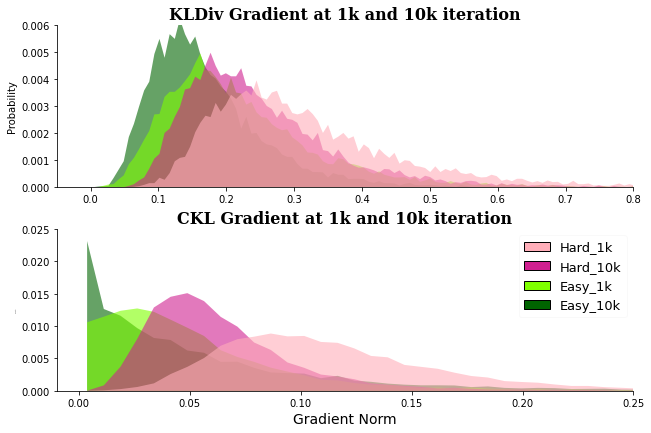

In [3]:
import seaborn as sns
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

sns.set_style()
nbin = 100
colors = ['#FFAEB9', '#D02090', '#7FFF00', '#006400']

chart = sns.displot(data=df, x =  'norm', kind='hist', hue='type', row='loss', 
            linewidth=3, palette = colors,fill=True, stat='probability',edgecolor=None,
            legend=False,height = 3, aspect = 3, alpha = 0.6,
            facet_kws={'sharex': False, 'sharey':False}, element="poly")


chart.axes[0][0].set_xlim(-0.05,0.8)
chart.axes[1][0].set_xlim(-0.01,0.25)
chart.axes[0][0].set_ylim(0,0.006)
chart.axes[1][0].set_ylim(0,0.025)

plt.xlabel("Gradient Norm",fontsize = 14)
plt.ylabel("Probability",fontsize = 0.007)
chart.axes[0][0].set_title("KLDiv Gradient at 1k and 10k iteration", fontsize = 16, fontname = 'serif', fontweight="bold")
chart.axes[1][0].set_title("CKL Gradient at 1k and 10k iteration", fontsize = 16, fontname = 'serif', fontweight="bold")
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in colors]
labels= ["Hard_1k","Hard_10k", "Easy_1k","Easy_10k"]
plt.legend(handles, labels, fontsize=13,facecolor='white', framealpha=0.1)

plt.savefig('grad.pdf',dpi=300,  bbox_inches='tight')
plt.show()